# 0. 데이터 정리

## 0 - 1. 필요 라이브러리 임포트

In [1]:
import torch # 파이토치 
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)                # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)             # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)          # 파이토치 난수 생성기 시드 고정 (CPU 사용 시)
torch.cuda.manual_seed(seed)     # 파이토치 난수 생성기 시드 고정 (GPU 사용 시)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정 (멀티GPU 사용 시)
torch.backends.cudnn.deterministic = True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False    # 벤치마크 기능 해제
torch.backends.cudnn.enabled = False      # cudnn 사용 해제

In [2]:
import torch 
import random

import torchvision
from torchvision import datasets 
from torchvision import transforms

import glob
import os
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np
import cv2

from PIL import Image

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F


import albumentations as A
from albumentations.pytorch import ToTensorV2
from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## 0-2. GPU 셋팅

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
!nvidia-smi

Wed Apr 19 03:41:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:17:00.0 Off |                   On |
| N/A   30C    P0    43W / 300W |                  N/A |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+

+-----------------------------------------------------------------------------+
| MIG d

# 1. 데이터 불러오기

In [5]:
filepath = glob.glob('dobae/open/train/*/*.png')

In [6]:
df = pd.DataFrame(columns=['image', 'label'])
df['image'] = filepath
df['label'] = df['image'].str.split('/').str[-2]

In [7]:
df.iloc[35], len(filepath)

(image    dobae/open/train/걸레받이수정/60.png
 label                            걸레받이수정
 Name: 35, dtype: object,
 3457)

In [7]:
encoder = LabelEncoder()
encoder.fit(df['label'])
labels = encoder.transform(df['label'])
df['label_encode'] = labels
# encoding.inverse_transform #(encoding 한 코드 다시 원본으로 )

## 이미지 크기 확인

In [9]:
filepath[1]

'dobae/open/train/녹오염/9.png'

In [40]:
image_x = []
image_y = []
for i in filepath:
    image = Image.open(i)
    image_x.append(image.size[0])
    image_y.append(image.size[1])

In [45]:
sum(image_x)/len(image_x)

645.6253977437084

In [46]:
sum(image_y)/len(image_x)

626.7897020538039

In [48]:
max(image_x), min(image_x)

(1425, 357)

## 이미지 선명하게

In [7]:
def repeat_aug(count=4, orig_image=None, label=None, augmentor=None):
    image_list = [orig_image]
    label_list = ['Original']

    for i in range(count):
        augmented_image = augmentor(image=orig_image)
        image_list.append(augmented_image)
        label_list.append(label)

    figure, axes = plt.subplots(nrows=1, ncols=count+1, figsize=(22, 4))
    for i in range(count+1):
        axes[i].imshow(image_list[i])
        axes[i].set_title(label_list[i])

In [8]:
image_exam = filepath[1357]

In [9]:
image = cv2.imread(image_exam)
orig_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## 데이터셋 나누기 

In [8]:
train_set, valid_set , _,_ = train_test_split(df,df['label_encode'],test_size=0.2, stratify=df['label_encode'],random_state=42)
# stratify : class 비율을 일정하게 만들어 준다. Target 값으로 넣어주면 그 값의 비율에 맞게 나누어 주기 때문에 꼭 필요!

## 전처리기 만들기 

In [9]:
class MyData(Dataset):
    def __init__(self, image_filepath, label_filepath, transform=None):
        self.image_filepath = image_filepath
        self.label_filepath = label_filepath
        self.transform = transform

    def __len__(self):
        return len(self.image_filepath)

    def __getitem__(self,index):

        image = self.image_filepath[index]
        image = Image.open(image) # .convert('RGB')
        image = np.asarray(image) # 알버트 이미지 변환을 하기 위한 작업 

        if self.transform is not None: # 트랜스폼 처리가 존재하면 
            image = self.transform(image=image)['image']

        if self.label_filepath is not None: # 해당 데이터에 파일 패스가 존재하면 레이블도 함께 받아오기
            label = self.label_filepath[index]
            return image, label
        else:
            return image

In [10]:
transform = A.Compose([A.Resize(300, 300), A.CLAHE(p=0.3),A.Normalize(), 
                       A.RandomRotate90(), A.HorizontalFlip(p=0.5), 
                       A.VerticalFlip(p=0.3), ToTensorV2()])
# 변환기

In [11]:
trainset = MyData(train_set['image'].values, train_set['label_encode'].values,transform=transform)
validset = MyData(valid_set['image'].values, valid_set['label_encode'].values,transform=transform)

In [26]:
len(trainset), len(validset)

(2765, 692)

In [14]:
trainset[0]

(tensor([[[ 2.1462,  2.0434,  1.8722,  ...,  0.0912,  0.2282,  0.6392],
          [ 2.0777,  2.1119,  1.9407,  ...,  0.5193,  0.5022,  0.4337],
          [ 2.1290,  2.0434,  1.9235,  ...,  0.3994,  0.5878,  0.1426],
          ...,
          [ 2.0263,  2.0092,  2.1804,  ..., -0.7308, -0.7479, -0.7308],
          [ 1.9578,  1.9920,  2.0948,  ..., -0.7650, -0.7479, -0.7650],
          [ 1.9749,  2.0092,  2.0605,  ..., -0.7479, -0.7308, -0.7308]],
 
         [[ 2.1310,  2.0084,  1.8333,  ...,  0.1527,  0.2927,  0.7129],
          [ 2.0434,  2.1310,  1.9559,  ...,  0.5903,  0.5378,  0.4503],
          [ 2.0959,  2.0434,  1.9384,  ...,  0.3978,  0.6254,  0.1877],
          ...,
          [ 2.1134,  2.1485,  2.3585,  ..., -0.6527, -0.6702, -0.6527],
          [ 2.0609,  2.0959,  2.2360,  ..., -0.6877, -0.6877, -0.6877],
          [ 2.0084,  2.0609,  2.1485,  ..., -0.6702, -0.6527, -0.6527]],
 
         [[ 2.0648,  1.9428,  1.7685,  ...,  0.1651,  0.3045,  0.7228],
          [ 1.9777,  2.0474,

# 2. 데이터 시각화

In [29]:
# 한국어를 실행을 하지 못함
labels_map = {7 :'몰딩수정', 9:'석고수정', 18:'훼손', 17:'피스', 4:'녹오염', 0:'가구수정', 10:'오염', 5:'들뜸' , 2:'곰팡이',
 14:'창틀,문틀수정', 12:'울음', 11:'오타공', 8:'반점', 6:'면불량', 15:'터짐', 16:'틈새과다' , 1:'걸레받이수정'
 ,13:'이음부불량', 3:'꼬임'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

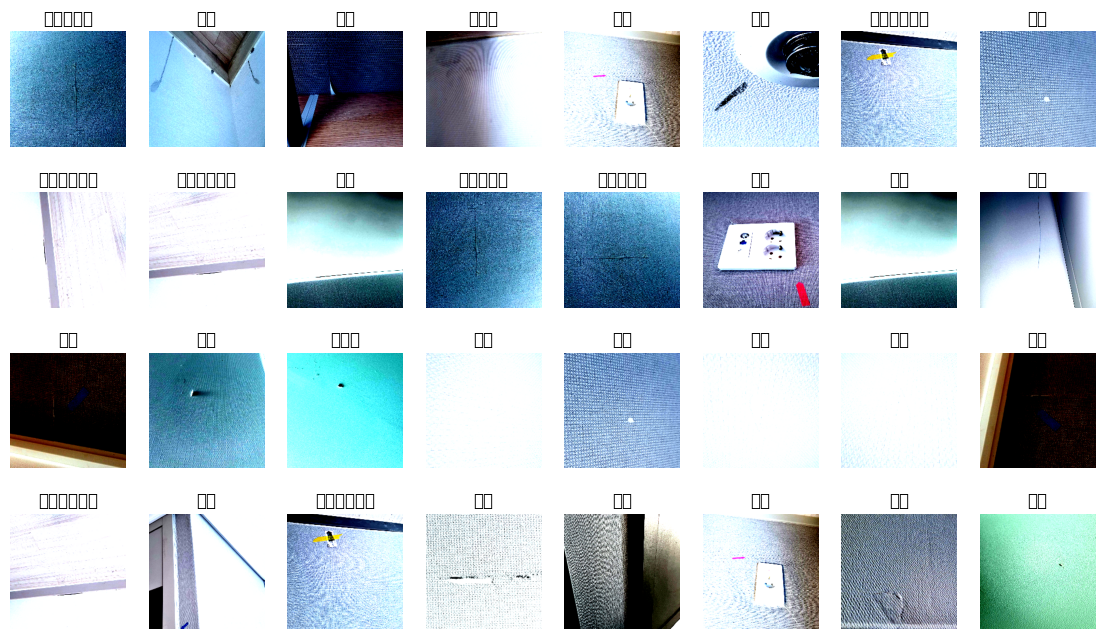

In [32]:
figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(14, 8))
axes = axes.flatten()

for i in range(32):
    rand_i = np.random.randint(0, 32)
    result = imageset[rand_i]
    image, label = result[0], result[1]
    axes[i].axis('off')
    axes[i].imshow(image.permute(1,2,0))
    axes[i].set_title(labels_map[label])
    plt.show

# 3. 데이터 적재 

In [12]:
batch_size = 8 
# dataloader = DataLoader(데이터셋, 배치사이즈, 셔플여부.....)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # 훈련용 2765개 데이터
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False) # 검증용 692개 데이터

In [28]:
print(type(trainloader),len(trainloader))
print(type(validloader), len(validloader))

<class 'torch.utils.data.dataloader.DataLoader'> 346
<class 'torch.utils.data.dataloader.DataLoader'> 87


In [13]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
images.size(), labels.size()

(torch.Size([8, 3, 300, 300]), torch.Size([8]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


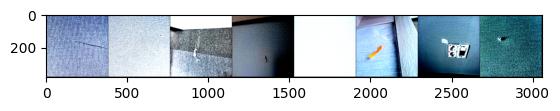

In [18]:
grid_img = torchvision.utils.make_grid(images)
plt.imshow(grid_img.permute(1, 2, 0))

# 4. 모델 생성

In [14]:
import torch.nn as nn # 파이토치에서 제공하는 다양한 계층 (Linear Layer, ....)
import torch.optim as optim # 옵티마이저 (경사하강법...)
import torch.nn.functional as F # 파이토치에서 제공하는 함수(활성화 함수...)

In [15]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=19)
model.to(device)

Loaded pretrained weights for efficientnet-b4


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

# 5. 모델 컴파일

```
batchsize = 8
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=19)
model.to(device)
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)
```

In [16]:
# batchsize = 8
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

In [17]:
out = model(images.to(device))
out.shape

torch.Size([8, 19])

In [24]:
for parameter in model.parameters():
    print(parameter.requires_grad) # 수정 전

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [22]:
# Freeze all the layers in the model
for name, param in model.named_parameters():
    param.requires_grad = False

# Unfreeze the final few layers for fine-tuning
for name, param in model.named_parameters():
    if '_fc' in name or '_conv_head' in name:
        param.requires_grad = True

In [33]:
for parameter in model.parameters():
    print(parameter.requires_grad) # 수정 후

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [25]:
# Print the number of trainable and frozen parameters
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f'Number of trainable parameters: {num_trainable_params}')
print(f'Number of frozen parameters: {num_frozen_params}')

Number of trainable parameters: 17582683
Number of frozen parameters: 0


# 6. 모델 훈련 

In [18]:
def validate(model, validloader, loss_fn):
  total = 0   
  correct = 0
  valid_loss = 0
  valid_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
  with torch.no_grad():
    for images, labels in validloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)      
      # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten !!
      # images.resize_(images.size()[0], 784)

      # 2. 전방향(Forward) 예측
      logit = model(images) # 예측 점수
      _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
      # preds = logit.max(dim=1)[1] 
      correct += int((preds == labels).sum()) # 배치 중 맞은 것의 개수가 correct에 누적
      total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

      loss = loss_fn(logit, labels)
      valid_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

    valid_accuracy = correct / total
  
  return valid_loss, valid_accuracy

In [19]:

def train_loop(model, trainloader, loss_fn, epochs, optimizer):  
  steps = 0
  steps_per_epoch = len(trainloader) 
  min_loss = 1000000
  max_accuracy = 0
  trigger = 0
  patience = 7 

  for epoch in range(epochs):
    model.train() # 훈련 모드
    train_loss = 0
    for images, labels in trainloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
      steps += 1
      # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten !!
      # images.resize_(images.shape[0], 784) 

      # 2. 전방향(forward) 예측
      predict = model(images) # 예측 점수
      loss = loss_fn(predict, labels) # 예측 점수와 정답을 CrossEntropyLoss에 넣어 Loss값 반환

      # 3. 역방향(backward) 오차(Gradient) 전파
      optimizer.zero_grad() # Gradient가 누적되지 않게 하기 위해
      loss.backward() # 모델파리미터들의 Gradient 전파

      # 4. 경사 하강법으로 모델 파라미터 업데이트
      optimizer.step() # W <- W -lr*Gradient

      train_loss += loss.item()
      if (steps % steps_per_epoch) == 0 : 
        model.eval() # 평가 모드 : 평가에서 사용하지 않을 계층(배치 정규화, 드롭아웃)들을 수행하지 않게 하기 위해서
        valid_loss, valid_accuracy = validate(model, validloader, loss_fn)

        print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
              'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
              'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
              'Valid Accuracy : {:.3f}'.format(valid_accuracy)            
              )
        
        # Best model 저장    
        # option 1 : valid_loss 모니터링
        # if valid_loss < min_loss: # 바로 이전 epoch의 loss보다 작으면 저장하기
        #   min_loss = valid_loss
        #   best_model_state = deepcopy(model.state_dict())          
        #   torch.save(best_model_state, 'best_checkpoint.pth')     
        
        # option 2 : valid_accuracy 모니터링      
        if valid_accuracy > max_accuracy : # 바로 이전 epoch의 accuracy보다 크면 저장하기
          max_accuracy = valid_accuracy
          best_model_state = deepcopy(model.state_dict())          
          torch.save(best_model_state, 'best_checkpoint.pth')  
        # -------------------------------------------

        # Early Stopping (조기 종료)
        if valid_loss > min_loss: # valid_loss가 min_loss를 갱신하지 못하면
          trigger += 1
          print('trigger : ', trigger)
          if trigger > patience:
            print('Early Stopping !!!')
            print('Training loop is finished !!') 
            return
        else:
          trigger = 0
          min_loss = valid_loss
        # -------------------------------------------

        # Learning Rate Scheduler
        scheduler.step(valid_loss)
        # -------------------------------------------
        

  return  

In [20]:
epochs = 100
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)

Epoch : 1/100....... Train Loss : 1.563 Valid Loss : 2.504 Valid Accuracy : 0.556
Epoch : 2/100....... Train Loss : 1.253 Valid Loss : 1.357 Valid Accuracy : 0.614
Epoch : 3/100....... Train Loss : 1.079 Valid Loss : 1.174 Valid Accuracy : 0.714
Epoch : 4/100....... Train Loss : 0.993 Valid Loss : 1.349 Valid Accuracy : 0.658
trigger :  1
Epoch : 5/100....... Train Loss : 0.900 Valid Loss : 1.005 Valid Accuracy : 0.704
Epoch : 6/100....... Train Loss : 0.830 Valid Loss : 1.043 Valid Accuracy : 0.728
trigger :  1
Epoch : 7/100....... Train Loss : 0.760 Valid Loss : 0.851 Valid Accuracy : 0.757
Epoch : 8/100....... Train Loss : 0.740 Valid Loss : 1.329 Valid Accuracy : 0.684
trigger :  1
Epoch : 9/100....... Train Loss : 0.688 Valid Loss : 0.880 Valid Accuracy : 0.738
trigger :  2
Epoch : 10/100....... Train Loss : 0.620 Valid Loss : 0.945 Valid Accuracy : 0.723
trigger :  3
Epoch : 11/100....... Train Loss : 0.641 Valid Loss : 0.980 Valid Accuracy : 0.736
trigger :  4
Epoch : 12/100....

# 7. 모델 예측

In [21]:
test_set = glob.glob('./dobae/open/test/*.png')
test_set.sort()
test_set

['./dobae/open/test/000.png',
 './dobae/open/test/001.png',
 './dobae/open/test/002.png',
 './dobae/open/test/003.png',
 './dobae/open/test/004.png',
 './dobae/open/test/005.png',
 './dobae/open/test/006.png',
 './dobae/open/test/007.png',
 './dobae/open/test/008.png',
 './dobae/open/test/009.png',
 './dobae/open/test/010.png',
 './dobae/open/test/011.png',
 './dobae/open/test/012.png',
 './dobae/open/test/013.png',
 './dobae/open/test/014.png',
 './dobae/open/test/015.png',
 './dobae/open/test/016.png',
 './dobae/open/test/017.png',
 './dobae/open/test/018.png',
 './dobae/open/test/019.png',
 './dobae/open/test/020.png',
 './dobae/open/test/021.png',
 './dobae/open/test/022.png',
 './dobae/open/test/023.png',
 './dobae/open/test/024.png',
 './dobae/open/test/025.png',
 './dobae/open/test/026.png',
 './dobae/open/test/027.png',
 './dobae/open/test/028.png',
 './dobae/open/test/029.png',
 './dobae/open/test/030.png',
 './dobae/open/test/031.png',
 './dobae/open/test/032.png',
 './dobae/

In [22]:
testset = MyData(test_set, label_filepath= None,transform=transform)

In [23]:
len(testset)

792

In [24]:
testloader = DataLoader(testset,batch_size=batch_size, shuffle=False)

test_iter = iter(testloader)
images = next(test_iter)

In [25]:
test_set[0]

'./dobae/open/test/000.png'

In [26]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for images in testloader:
            imgs = images.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    
    return preds
preds = inference(model, testloader, device)

In [27]:
len(preds)

792

In [28]:
submit = pd.read_csv('dobae/open/sample_submission.csv')

In [29]:
submit['label'] = preds
submit.head(3)

,id,label
0,TEST_000,18
1,TEST_001,10
2,TEST_002,18


In [30]:
submit.loc[submit['label'] == 0, 'label'] = '가구수정'
submit.loc[submit['label'] == 1, 'label'] = '걸레받이수정'
submit.loc[submit['label'] == 2, 'label'] = '곰팡이'
submit.loc[submit['label'] == 3, 'label'] = '꼬임'
submit.loc[submit['label'] == 4, 'label'] = '녹오염'
submit.loc[submit['label'] == 5, 'label'] = '들뜸'
submit.loc[submit['label'] == 6, 'label'] = '면불량'
submit.loc[submit['label'] == 7, 'label'] = '몰딩수정'
submit.loc[submit['label'] == 8, 'label'] = '반점'
submit.loc[submit['label'] == 9, 'label'] = '석고수정'
submit.loc[submit['label'] == 10, 'label'] = '오염'
submit.loc[submit['label'] == 11, 'label'] = '오타공'
submit.loc[submit['label'] == 12, 'label'] = '울음'
submit.loc[submit['label'] == 13, 'label'] = '이음부불량'
submit.loc[submit['label'] == 14, 'label'] = '창틀,문틀수정'
submit.loc[submit['label'] == 15, 'label'] = '터짐'
submit.loc[submit['label'] == 16, 'label'] = '틈새과다'
submit.loc[submit['label'] == 17, 'label'] = '피스'
submit.loc[submit['label'] == 18, 'label'] = '훼손'

In [31]:
submit

,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,오염
...,...,...
787,TEST_787,훼손
788,TEST_788,오염
789,TEST_789,오염
790,TEST_790,오염


In [32]:
submit.to_csv('./4_19_오후_EFB4_resize300_common.csv', index=False)

In [ ]:
# 결과
Epoch : 40/100....... Train Loss : 0.517 Valid Loss : 1.015 Valid Accuracy : 0.711
점수 : 0.421343637

# 8. 모델평가 및 모델 베스트 & 라스트 체크포인트 분석

In [33]:
model.state_dict().keys()

odict_keys(['_conv_stem.weight', '_bn0.weight', '_bn0.bias', '_bn0.running_mean', '_bn0.running_var', '_bn0.num_batches_tracked', '_blocks.0._depthwise_conv.weight', '_blocks.0._bn1.weight', '_blocks.0._bn1.bias', '_blocks.0._bn1.running_mean', '_blocks.0._bn1.running_var', '_blocks.0._bn1.num_batches_tracked', '_blocks.0._se_reduce.weight', '_blocks.0._se_reduce.bias', '_blocks.0._se_expand.weight', '_blocks.0._se_expand.bias', '_blocks.0._project_conv.weight', '_blocks.0._bn2.weight', '_blocks.0._bn2.bias', '_blocks.0._bn2.running_mean', '_blocks.0._bn2.running_var', '_blocks.0._bn2.num_batches_tracked', '_blocks.1._depthwise_conv.weight', '_blocks.1._bn1.weight', '_blocks.1._bn1.bias', '_blocks.1._bn1.running_mean', '_blocks.1._bn1.running_var', '_blocks.1._bn1.num_batches_tracked', '_blocks.1._se_reduce.weight', '_blocks.1._se_reduce.bias', '_blocks.1._se_expand.weight', '_blocks.1._se_expand.bias', '_blocks.1._project_conv.weight', '_blocks.1._bn2.weight', '_blocks.1._bn2.bias', '

## 라스트 모델

In [34]:
torch.save(model.state_dict(), 'last_checkpoint.pth')

In [35]:
last_state_dict = torch.load('last_checkpoint.pth')

In [36]:
last_model = model
last_model.to(device)
last_model.load_state_dict(last_state_dict)

<All keys matched successfully>

In [37]:
last_model.eval()
last_preds = inference(last_model, testloader, device)

In [38]:
len(last_preds)

792

In [39]:
submit = pd.read_csv('dobae/open/sample_submission.csv')
submit

,id,label
0,TEST_000,훼손
1,TEST_001,훼손
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,훼손
...,...,...
787,TEST_787,훼손
788,TEST_788,훼손
789,TEST_789,훼손
790,TEST_790,훼손


In [40]:
submit['label'] = last_preds
submit

,id,label
0,TEST_000,18
1,TEST_001,10
2,TEST_002,18
3,TEST_003,7
4,TEST_004,10
...,...,...
787,TEST_787,18
788,TEST_788,10
789,TEST_789,10
790,TEST_790,10


In [41]:
submit.loc[submit['label'] == 0, 'label'] = '가구수정'
submit.loc[submit['label'] == 1, 'label'] = '걸레받이수정'
submit.loc[submit['label'] == 2, 'label'] = '곰팡이'
submit.loc[submit['label'] == 3, 'label'] = '꼬임'
submit.loc[submit['label'] == 4, 'label'] = '녹오염'
submit.loc[submit['label'] == 5, 'label'] = '들뜸'
submit.loc[submit['label'] == 6, 'label'] = '면불량'
submit.loc[submit['label'] == 7, 'label'] = '몰딩수정'
submit.loc[submit['label'] == 8, 'label'] = '반점'
submit.loc[submit['label'] == 9, 'label'] = '석고수정'
submit.loc[submit['label'] == 10, 'label'] = '오염'
submit.loc[submit['label'] == 11, 'label'] = '오타공'
submit.loc[submit['label'] == 12, 'label'] = '울음'
submit.loc[submit['label'] == 13, 'label'] = '이음부불량'
submit.loc[submit['label'] == 14, 'label'] = '창틀,문틀수정'
submit.loc[submit['label'] == 15, 'label'] = '터짐'
submit.loc[submit['label'] == 16, 'label'] = '틈새과다'
submit.loc[submit['label'] == 17, 'label'] = '피스'
submit.loc[submit['label'] == 18, 'label'] = '훼손'

In [42]:
submit

,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,훼손
3,TEST_003,몰딩수정
4,TEST_004,오염
...,...,...
787,TEST_787,훼손
788,TEST_788,오염
789,TEST_789,오염
790,TEST_790,오염


In [50]:
submit.to_csv('./4_19_오후_EFB4_resize300_last.csv', index=False)

## 베스트 모델

In [44]:
best_state_dict = torch.load('best_checkpoint.pth')
best_model = model
best_model.to(device)
best_model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [45]:
last_model.eval()
best_preds= inference(best_model, testloader, device)

In [46]:
submit = pd.read_csv('dobae/open/sample_submission.csv')
submit

,id,label
0,TEST_000,훼손
1,TEST_001,훼손
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,훼손
...,...,...
787,TEST_787,훼손
788,TEST_788,훼손
789,TEST_789,훼손
790,TEST_790,훼손


In [47]:
submit['label'] = best_preds
submit

,id,label
0,TEST_000,18
1,TEST_001,10
2,TEST_002,18
3,TEST_003,7
4,TEST_004,10
...,...,...
787,TEST_787,18
788,TEST_788,10
789,TEST_789,10
790,TEST_790,10


In [48]:
submit.loc[submit['label'] == 0, 'label'] = '가구수정'
submit.loc[submit['label'] == 1, 'label'] = '걸레받이수정'
submit.loc[submit['label'] == 2, 'label'] = '곰팡이'
submit.loc[submit['label'] == 3, 'label'] = '꼬임'
submit.loc[submit['label'] == 4, 'label'] = '녹오염'
submit.loc[submit['label'] == 5, 'label'] = '들뜸'
submit.loc[submit['label'] == 6, 'label'] = '면불량'
submit.loc[submit['label'] == 7, 'label'] = '몰딩수정'
submit.loc[submit['label'] == 8, 'label'] = '반점'
submit.loc[submit['label'] == 9, 'label'] = '석고수정'
submit.loc[submit['label'] == 10, 'label'] = '오염'
submit.loc[submit['label'] == 11, 'label'] = '오타공'
submit.loc[submit['label'] == 12, 'label'] = '울음'
submit.loc[submit['label'] == 13, 'label'] = '이음부불량'
submit.loc[submit['label'] == 14, 'label'] = '창틀,문틀수정'
submit.loc[submit['label'] == 15, 'label'] = '터짐'
submit.loc[submit['label'] == 16, 'label'] = '틈새과다'
submit.loc[submit['label'] == 17, 'label'] = '피스'
submit.loc[submit['label'] == 18, 'label'] = '훼손'

In [49]:
submit

,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,훼손
3,TEST_003,몰딩수정
4,TEST_004,오염
...,...,...
787,TEST_787,훼손
788,TEST_788,오염
789,TEST_789,오염
790,TEST_790,오염


In [51]:
submit.to_csv('./4_19_오후_EFB4_resize300_best.csv', index=False)

# 9. 비교하기

In [52]:
compare_df = pd.DataFrame(columns=['common_preds', 'last_preds', 'best_preds'])

In [53]:
compare_df['common_preds'] = preds
compare_df['last_preds'] = last_preds
compare_df['best_preds'] = best_preds

In [55]:
compare_df.to_csv('4_18_오후_compare_preds_Ver_resize300.csv', index=False)

In [56]:
compare_df

,common_preds,last_preds,best_preds
0,18,18,18
1,10,10,10
2,18,18,18
3,18,7,7
4,10,10,10
...,...,...,...
787,18,18,18
788,10,10,10
789,10,10,10
790,10,10,10
